In [32]:
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt

In [33]:
basepath = '../../../results'
output_file_path = os.path.join(basepath, 'plots/wiki_all_models_ten_syntactic_constructions.png')
wiki_files = glob.glob(os.path.join(basepath, 'results_wiki1xv*_MARVINLINZEN_by_clause/*wiki_seed100.txt'))

In [34]:
# collect a list of syntactic constructions
dfs = {}
constructions = None

for i, f in enumerate(wiki_files):
    tag = os.path.dirname(f).strip().split('_')[1]

    filename = os.path.basename(f)
    filename_parts = filename.strip().split('_')

    if "xlnet" in filename:
        model_name = '_'.join(filename_parts[:2])
    else:
        model_name = filename_parts[0]
        model_name = model_name.split('-')[0]

    dfname = f'{model_name}-{tag}'

    cdf = pd.read_csv(f)
    cdf = cdf.set_index('group')
    cdf = cdf.T

    constructions = set(list(cdf.columns))
    
    dfs[dfname] = cdf
    

In [35]:
construction_dfs = {}

for c in constructions:
    
    list_of_dfs = []

    for dfname, df in dfs.items():
        thisdf = df[c].to_frame('f1')
        # thisdf = df[c]
        thisdf = thisdf.reset_index().rename(columns={'index': 'layer'})
        thisdf['model'] = dfname if 'wifce' in dfname else dfname[:-2]
        thisdf = thisdf.rename(columns={c: 'f1'})
        list_of_dfs.append(thisdf)

    construction_dfs[c] = pd.concat(list_of_dfs, axis=0)
    construction_dfs[c] = construction_dfs[c].astype({'layer':'int32'})
    construction_dfs[c] = construction_dfs[c].reset_index().drop(['index'], axis=1)
    construction_dfs[c] = construction_dfs[c].sort_values(by=['model', 'layer'])


In [36]:
const2name = {
    'long_vp_coord': 'Long VP coord.',
    'obj_rel_across': 'Object rel. across',
    'obj_rel_no_comp_across': 'Object rel. across (no comp)',
    'obj_rel_no_comp_within': 'Object rel. with (no comp)',
    'obj_rel_within': 'Object rel. within',
    'prep': 'Prepositional Phrase',
    'sent_comp': 'Sentential comp.',
    'simple': 'Simple Agreement',
    'subj_rel': 'Subject rel.',
    'vp_coord': 'Short VP coord'
}

In [37]:

baselines_scores = {
    'simple': 0.67,
    'sent_comp': 0.4,
    'vp_coord': 0.4,
    'long_vp_coord': 0.3,
    'prep': 0.67,
    'subj_rel': 0.4,
    'obj_rel_across': 0.4,
    'obj_rel_no_comp_across': 0.4,
    'obj_rel_within': 0.4,
    'obj_rel_no_comp_within': 0.4
}


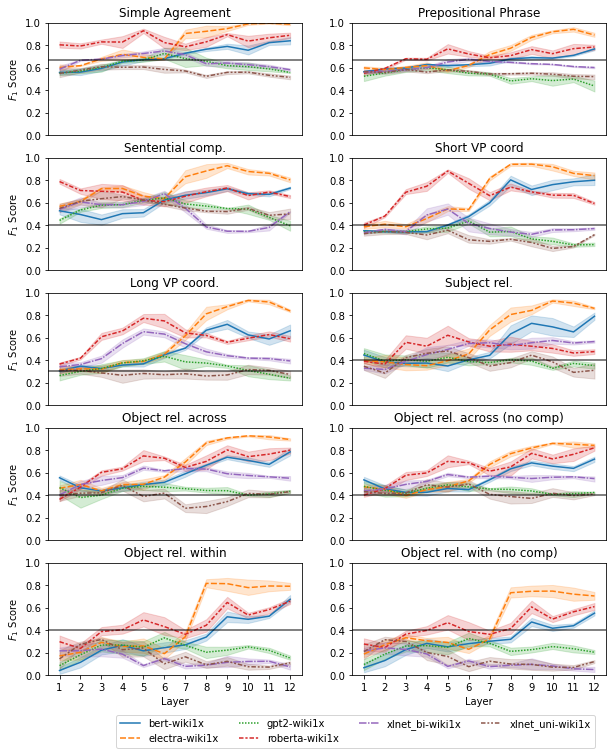

In [38]:
# plot all graphs
#define dimensions of subplots (rows, columns)

nrows = 5
ncols = 2

# fig, axes = plt.subplots(5, 2,figsize=(10,10))
fig, axes = plt.subplots(nrows, ncols, figsize=(10,12))

construction_order = [
    'simple',
    'prep',
    'sent_comp',
    'vp_coord',
    'long_vp_coord',
    'subj_rel',
    'obj_rel_across',
    'obj_rel_no_comp_across',
    'obj_rel_within',
    'obj_rel_no_comp_within',
]

#create chart in each subplot
for i, c in enumerate(construction_order):
    
    # dashed lines
    dash_list = sns._core.unique_dashes(construction_dfs[c]['model'].unique().size+1)
    style = {key:value for key,value in zip(construction_dfs[c]['model'].unique(), dash_list)}

    # col and row indices
    row = int(i/ncols)
    col = int(i%ncols)

    myplot = sns.lineplot(data=construction_dfs[c], x='layer', y='f1', hue='model', ax=axes[row, col], style='model', dashes=style)
    myplot.set(ylim=(0, 1))

    myplot.axhline(baselines_scores[c], color=(0, 0, 0, 0.65))

    if col == 0:
        # set the y-axis label for the first column only
        myplot.set_ylabel('$F_{1}$ Score')
    else:
        myplot.set_ylabel('')
        # myplot.set(yticklabels=[])
        myplot.set(ylabel=None)
    
    if row == nrows-1:
        # bottom row
        myplot.set_xlabel('Layer')
    elif row == 0:
        # first row
        myplot.set(xticklabels=[])
        myplot.set(xlabel=None)
        myplot.tick_params(bottom=False)
    else:
        # middle rows
        myplot.set(xticklabels=[])
        myplot.set(xlabel=None)
        myplot.tick_params(bottom=False)

    myplot.set_title(const2name[c])

    if i != 0:
        # remove the legend for all but one subplot
        myplot.get_legend().remove()
    else:
        # adjust the legend position
        myplot.legend(loc='center left', bbox_to_anchor=(0.25, -5.3), ncol=4)

    myplot.set(xticks=sorted(set(construction_dfs[c].layer.values)))

In [39]:
fig = myplot.get_figure()
fig.savefig(output_file_path, bbox_inches="tight", dpi=300)